# Inception-v3 network using slim

* Prerequisites
  * `git clone https://github.com/tensorflow/models.git`
  * [Pretrained models](https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models)
* inception-v3를 직접 사용해보자.
* Add path to system enviornment
```bash
export PYTHONPATH="$HOME/models/research/slim/:$PYTHONPATH"
```
* or use `sys.path.append` like below

In [1]:
import os
import sys
# put your tensorflow "models" absolute path
#sys.path.append("/Users/ilguyi/models/research/slim")

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Load a Inception-v3 graph

In [2]:
from nets import inception_v3
# When you don't have a tensorflow models folder, use below syntax
#from tensorflow.contrib.slim.python.slim.nets import inception_v3

In [3]:
inputs = tf.placeholder(tf.float32, [None, 299, 299, 3])

In [4]:
with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
  logits, end_points = inception_v3.inception_v3(inputs,
                                                 num_classes=1001,
                                                 is_training=False)

In [5]:
print(logits)

Tensor("InceptionV3/Logits/SpatialSqueeze:0", shape=(?, 1001), dtype=float32)


In [6]:
for node in end_points:
  print(node)

Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
MaxPool_3a_3x3
Conv2d_3b_1x1
Conv2d_4a_3x3
MaxPool_5a_3x3
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
Mixed_7a
Mixed_7b
Mixed_7c
AuxLogits
AvgPool_1a
PreLogits
Logits
Predictions


In [7]:
with tf.Session() as sess:
  writer = tf.summary.FileWriter("./graphs/05.inception_v3.slim", sess.graph)
  writer.close()

### Download the Inception-v3 checkpoint: 

```
$ CHECKPOINT_DIR='../../checkpoints'
$ mkdir ${CHECKPOINT_DIR}
$ wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
$ tar -xvf inception_v3_2016_08_28.tar.gz
$ mv inception_v3_2016_08_28.tar.gz ${CHECKPOINT_DIR}
$ rm inception_v3_2016_08_28.tar.gz
```

In [8]:
# Download the Inception-v3 checkpoint: 
# if you already have a inception_v3.ckpt then skip and comment below commands
#CHECKPOINT_DIR='../checkpoints'
#!mkdir $CHECKPOINT_DIR
#!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
#!tar -xvf inception_v3_2016_08_28.tar.gz
#!mv inception_v3.ckpt $CHECKPOINT_DIR
#!rm inception_v3_2016_08_28.tar.gz
#print('done')

### Restore Inception_v3 weights using `tf.saver.restore`

#### Read a image

In [9]:
def inception_v3_preprocessing(image):
  """inceptino v3 image preprocessing

  Args:
    image (PIL image): image with shape [height, width, channels]
    
  Returns:
    image (np.int32): inception_v3 preprocessed image with shape [224, 224, 3]
  """
  image = image.resize((299, 299))
  image = np.asarray(image)
  image = image.astype(np.float32)
  image = image / 127.5 - 1.0
  
  return image

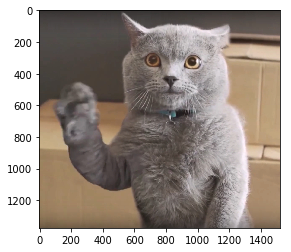

In [10]:
my_image = Image.open('../input_data/cat2.jpg')
plt.imshow(my_image)

In [11]:
my_image = inception_v3_preprocessing(my_image)
my_image = np.expand_dims(my_image, axis=0)

In [12]:
saver = tf.train.Saver()

with tf.Session(config=sess_config) as sess:

  # use saver object to load variables from the saved model
  saver.restore(sess, "../checkpoints/inception_v3.ckpt")
  
  # print conv1_1 weight itself
  conv1_1_w = sess.run(tf.trainable_variables()[0])
  
  # print feature maps
  conv2, conv4, \
  conv5, conv6, \
  conv7 = sess.run([end_points['Conv2d_2b_3x3'],
                    end_points['Conv2d_4a_3x3'],
                    end_points['Mixed_5d'],
                    end_points['Mixed_6e'],
                    end_points['Mixed_7c']],
                   feed_dict={inputs: my_image})

INFO:tensorflow:Restoring parameters from ../checkpoints/inception_v3.ckpt


In [13]:
for key in end_points.keys():
  print(key)

Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
MaxPool_3a_3x3
Conv2d_3b_1x1
Conv2d_4a_3x3
MaxPool_5a_3x3
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
Mixed_7a
Mixed_7b
Mixed_7c
AuxLogits
AvgPool_1a
PreLogits
Logits
Predictions


### Print feature maps

In [14]:
def print_all_feature_maps(layer, layer_name):
  """Print all feature maps
    This code is borrowed from "Deep Learning with Python" (by F. Chollet)
  
  Args:
    layer (4-rank Tensor): feature maps
    layer_name (string): name of feature maps
    
  Returns:
    print all feature maps
  """
  num_features = layer.shape[-1]
  size = layer.shape[1]
  images_per_row = 16
  for feature_map in range(num_features):
    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))

    for col in range(num_cols):
      for row in range(images_per_row):
        channel_image = layer[0,:,:,col * images_per_row + row]

        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image

  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

#### Print feature maps of `Conv2d_2b_3x3`

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


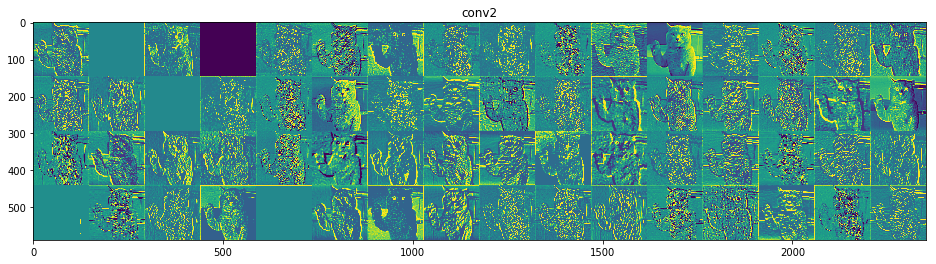

In [15]:
print_all_feature_maps(conv2, 'conv2')

#### Print feature maps of `Conv2d_4a_3x3`

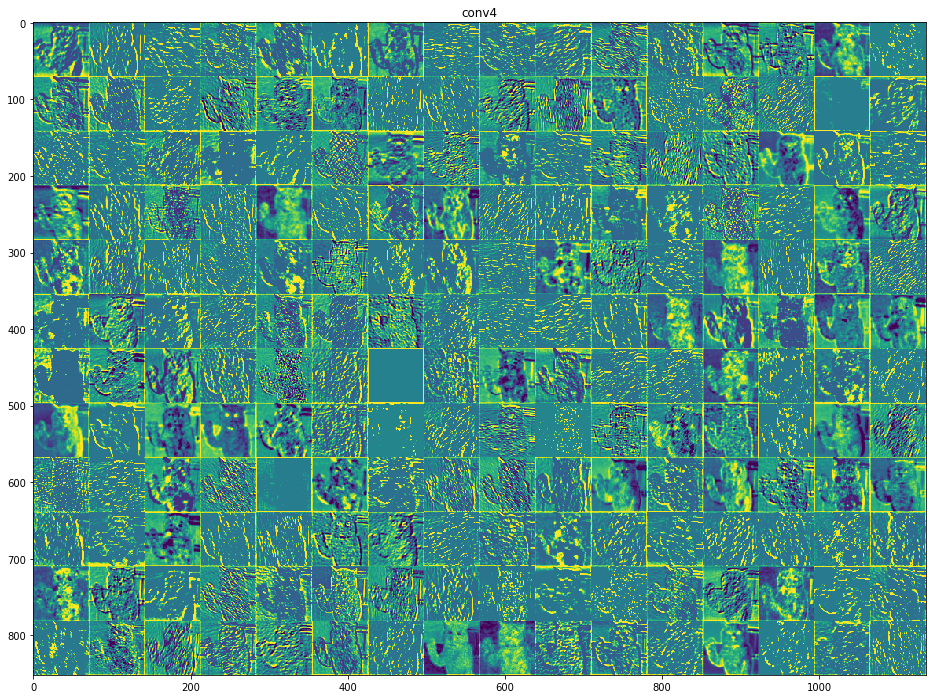

In [16]:
print_all_feature_maps(conv4, 'conv4')

#### Print feature maps of `Mixed_5d`

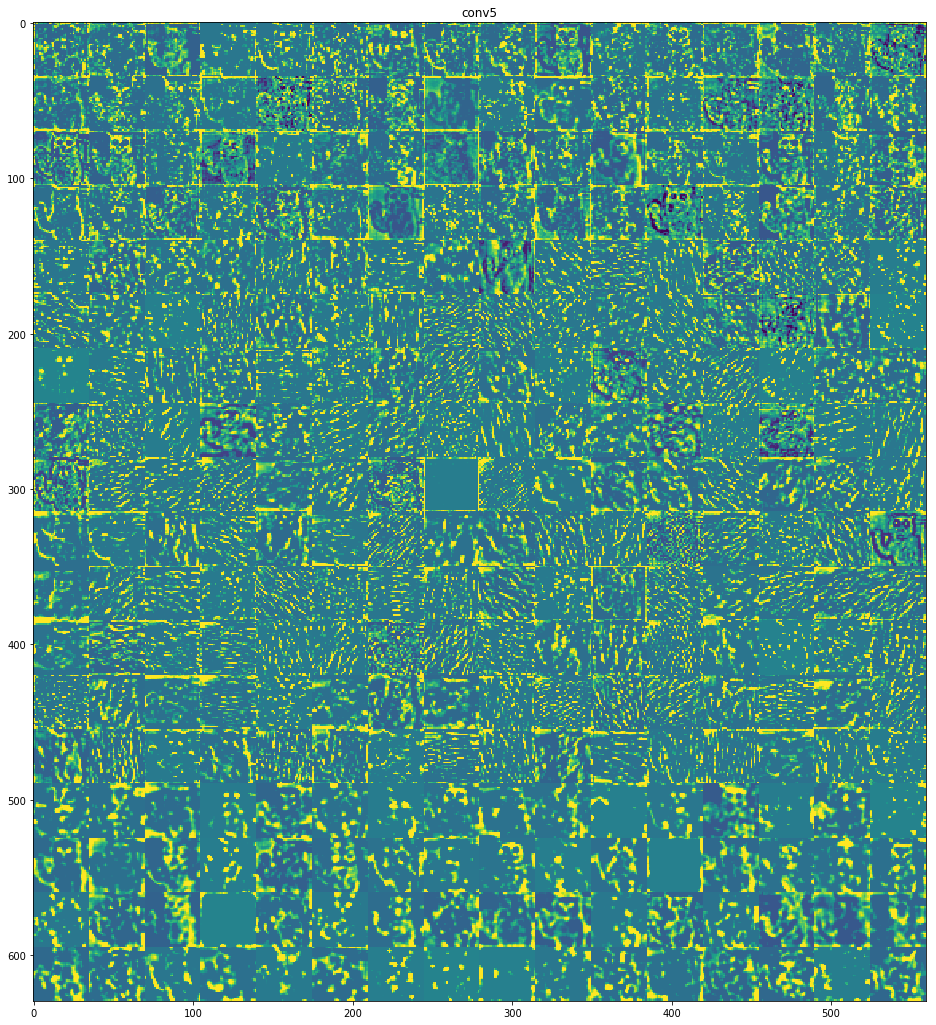

In [17]:
print_all_feature_maps(conv5, 'conv5')

#### Print feature maps of `Mixed_6e`

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


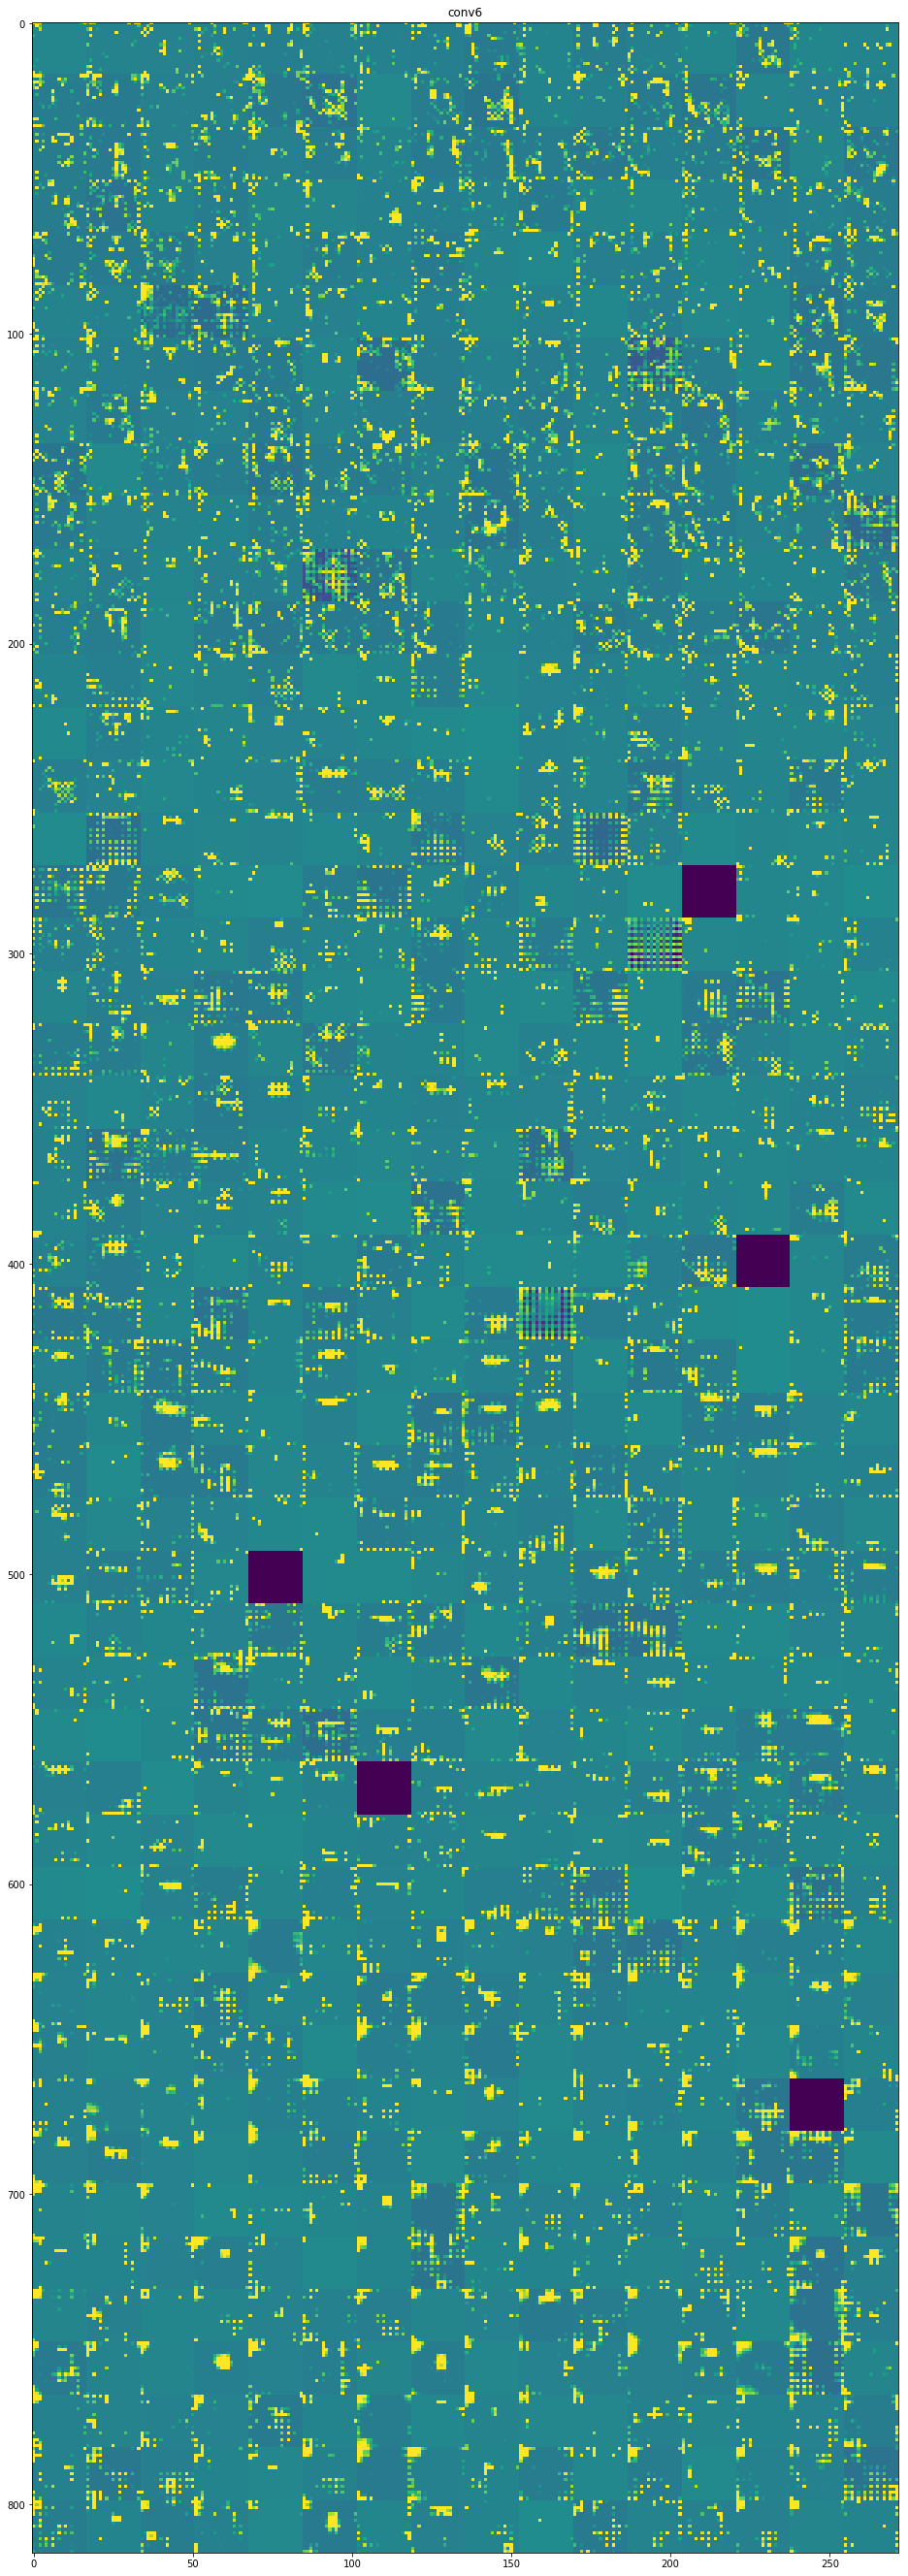

In [18]:
print_all_feature_maps(conv6, 'conv6')

#### Print feature maps of `Mixed_7c`

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


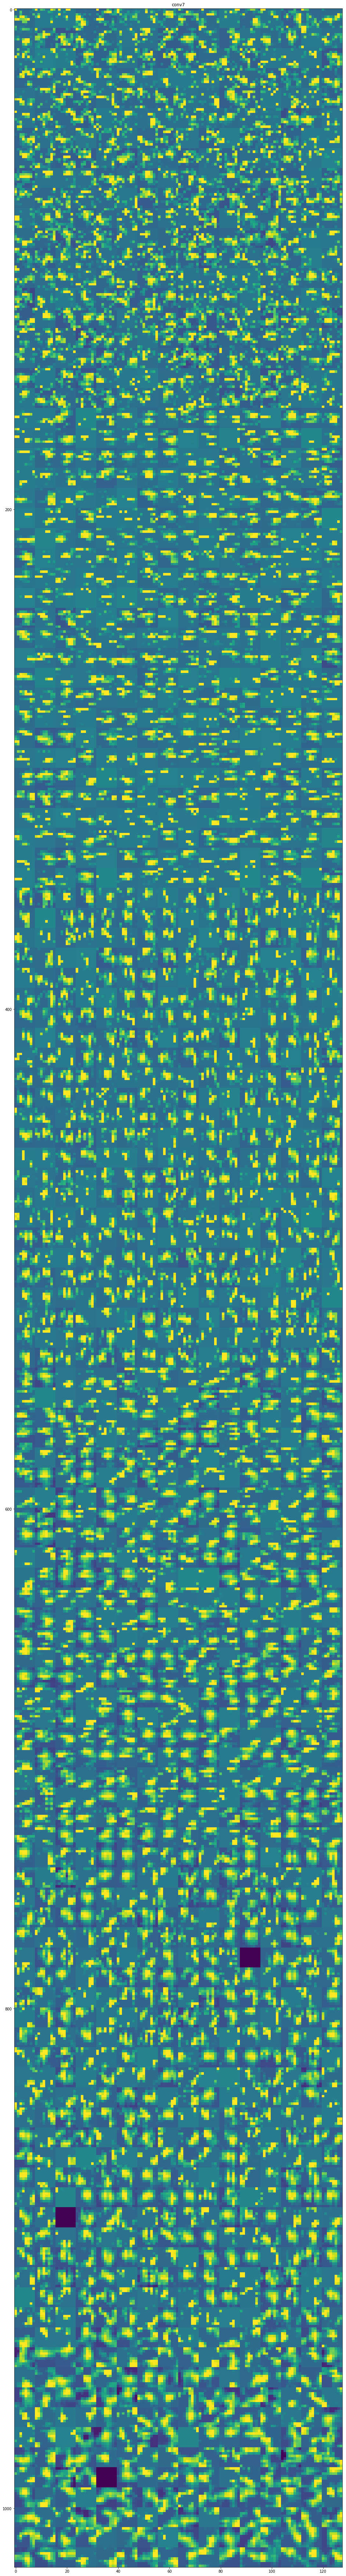

In [19]:
print_all_feature_maps(conv7, 'conv7')

In [20]:
print(conv7.shape)

(1, 8, 8, 2048)
